# Mini Project: Tree-Based Algorithms

## The "German Credit" Dataset

Also, since you want to be able to present the results of your model, we suggest you take a look at the tutorial for accuracy metrics for classification models (http://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) as well as the more detailed documentation (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

Finally, an *amazing* resource that explains the various classification model accuracy metrics, as well as the relationships between them, can be found on Wikipedia: https://en.wikipedia.org/wiki/Confusion_matrix

### Now we pass the torch onto you! You can start building your first Decision Tree model! :)

In [663]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
import time
from dtreeviz.trees import *

import catboost
from catboost import CatBoostClassifier

from dataprep.eda import plot as dataplot

from sklearn.inspection import permutation_importance

In [664]:
df=pd.read_csv("GermanCredit.csv")
#df.info()
df.head()
#dataplot(df)

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Class,...,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
0,6,1169,4,4,67,2,1,0,1,Good,...,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,1,Bad,...,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,1,Good,...,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,1,Good,...,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,Bad,...,0,0,1,0,0,1,0,0,1,0


In [665]:
#basic pre-processing
df.replace({"Good":1,"Bad":0}, inplace=True)
#print(df.describe())
print(df.Class.value_counts())

1    700
0    300
Name: Class, dtype: int64


In [666]:
def modelSearchResults(cv,mainMetric,params,scoring): #print all the results from grid or random search
    cv_results_df=pd.DataFrame(cv.cv_results_)
    tmp="rank_test_"+mainMetric
    bestRow=cv_results_df[cv_results_df[tmp]==1]
    bestRowIndex=bestRow.index[0]
    print("Iteration number for best",mainMetric,":",bestRowIndex)
    print("\nParameters for model with best",mainMetric,"from possible values:\n",params,":\n")
    for key in params.keys():
        val=bestRow['params'][bestRowIndex][key]
        if isinstance(val, str) != True: val=round(float(val),3)
        print(key,"value:",val)
    print("\nMetrics for model with best",mainMetric," from set of",scoring,":\n")
    for key in scoring:
        tmp="mean_test_"+key
        print(tmp,"value:",round(float(bestRow[tmp][bestRowIndex]),3))    
    y_pred = cv.best_estimator_.predict(X_validate)
    testFit=round(float(bestRow["mean_test_"+mainMetric][bestRowIndex]),3)
    if mainMetric == "precision" : validationFit=round(metrics.precision_score(y_validate, y_pred),3)
    if mainMetric == "accuracy" : validationFit=round(metrics.accuracy_score(y_validate, y_pred),3)
    if mainMetric == "recall" : validationFit=round(metrics.recall_score(y_validate, y_pred),3)
    if mainMetric == "matthews_corrcoef" : validationFit=round(metrics.matthews_corrcoef(y_validate, y_pred),3)
    if mainMetric == "roc_auc" : validationFit=round(metrics.roc_auc_score(y_validate, y_pred),3)
    print("\n",mainMetric,"on validation set is",validationFit,"to be compared with test",mainMetric,"of",testFit,", a",round(100.0*float(abs(validationFit-testFit)/testFit),1),"percent difference" )

    return [testFit,validationFit]

In [667]:
#global parameters
# we'll report on 5 metric:, accuracy, MCC, ROC AUC, precision and recall
# First let's set aside some data for final validation
finalValidationPercent=0.25
randomSeed=0
mainMetric="matthews_corrcoef"
mainMetricPermTreshold=0.01 # Will select (and remove) features that are below this threshold thru permutation
permutationFeatureDrop={} # {selectorName:[set of features below threashold],}
verbose=0
doViz=0 # 1 or 0, 0 to skip

scoring=["accuracy", "precision", "recall", "matthews_corrcoef", "roc_auc"]
#simple decision tree params
dtParams={"criterion":["entropy"],"max_depth":[10,20,50,100,250],"max_leaf_nodes":[10,50,250,1000,2500,10000]}
allResults={} #{classifier:{metricValues:[test,valid],'processTime':value,'bestEstimator':value,...}

#randomForest params
randomForestParameters = {'n_estimators': [100,200],"criterion":["entropy"],"max_depth":[10,20,50,100,250],"max_leaf_nodes":[10,50,250,1000,2500,10000]}
#randomForestParameters = {'n_estimators': [10],"criterion":["entropy"],"max_depth":[10,20],"max_leaf_nodes":[50,250,1000]} #testing only

#catBoost params
catBoostParameters = {'depth': [6,8],'iterations': [100,350,1000],'learning_rate': [0.02, 0.03, 0.04]}
#catBoostParameters = {'depth': [4,6],'iterations': [100],'learning_rate': [0.03]} #testing only

In [668]:
#Split train/test and validate
y=df['Class']
X=df.drop(columns=['Class'])
# partition data between train+test and validation, using stratification for unbalanced cases and seed for reproducibility.
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=finalValidationPercent,random_state=randomSeed,stratify=y) 

In [669]:
# Simple decision tree
regr=DecisionTreeClassifier(random_state=randomSeed)

start_time=time.time()
cv=GridSearchCV(estimator=regr,param_grid=dtParams,scoring=scoring,verbose=verbose,error_score='raise',refit=mainMetric)
cv.fit(X_train, y_train)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute model and metrics: {elapsed_time:.3f} seconds")
allResults['DecisionTreeClassifier']={}
allResults['DecisionTreeClassifier']['testAndValidMetric']=modelSearchResults(cv,mainMetric,dtParams,scoring)
allResults['DecisionTreeClassifier']['modelingTime']=elapsed_time
allResults['DecisionTreeClassifier']['bestEstimator']=bestEstimator

Elapsed time to compute model and metrics: 1.459 seconds
Iteration number for best matthews_corrcoef : 7

Parameters for model with best matthews_corrcoef from possible values:
 {'criterion': ['entropy'], 'max_depth': [10, 20, 50, 100, 250], 'max_leaf_nodes': [10, 50, 250, 1000, 2500, 10000]} :

criterion value: entropy
max_depth value: 20.0
max_leaf_nodes value: 50.0

Metrics for model with best matthews_corrcoef  from set of ['accuracy', 'precision', 'recall', 'matthews_corrcoef', 'roc_auc'] :

mean_test_accuracy value: 0.696
mean_test_precision value: 0.766
mean_test_recall value: 0.817
mean_test_matthews_corrcoef value: 0.243
mean_test_roc_auc value: 0.65

 matthews_corrcoef on validation set is 0.297 to be compared with test matthews_corrcoef of 0.243 , a 22.2 percent difference


### After you've built the best model you can, now it's time to visualize it!

In [670]:
#! pip install dtreeviz - Done from conda prompt

If for any reason this way of installing doesn't work for you straight out of the box, please refer to the more detailed documentation here: https://github.com/parrt/dtreeviz

In [671]:
from sklearn.datasets import *
from sklearn import tree
from dtreeviz.trees import *

classifier = tree.DecisionTreeClassifier() #max_depth=5
classifier.fit(X_train, y_train)

if doViz==1:
    viz = dtreeviz(classifier,  X_train,  y_train, target_name='Class', feature_names=df.columns)  
    viz.view()

## Random Forests
https://link.springer.com/content/pdf/10.1023%2FA%3A1010933404324.pdf.

In [672]:
# random forest
regr=RandomForestClassifier(random_state=randomSeed)

start_time=time.time()
cv=GridSearchCV(estimator=regr,param_grid=randomForestParameters,scoring=scoring,verbose=verbose,error_score='raise',refit=mainMetric)
cv.fit(X_train, y_train)
bestEstimator=cv.best_estimator_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute model and metrics: {elapsed_time:.3f} seconds")
allResults['RandomForestClassifier']={}
allResults['RandomForestClassifier']['testAndValidMetric']=modelSearchResults(cv,mainMetric,randomForestParameters,scoring)
allResults['RandomForestClassifier']['modelingTime']=elapsed_time
allResults['RandomForestClassifier']['bestEstimator']=bestEstimator


Elapsed time to compute model and metrics: 68.958 seconds
Iteration number for best matthews_corrcoef : 17

Parameters for model with best matthews_corrcoef from possible values:
 {'n_estimators': [100, 200], 'criterion': ['entropy'], 'max_depth': [10, 20, 50, 100, 250], 'max_leaf_nodes': [10, 50, 250, 1000, 2500, 10000]} :

n_estimators value: 200.0
criterion value: entropy
max_depth value: 20.0
max_leaf_nodes value: 250.0

Metrics for model with best matthews_corrcoef  from set of ['accuracy', 'precision', 'recall', 'matthews_corrcoef', 'roc_auc'] :

mean_test_accuracy value: 0.747
mean_test_precision value: 0.773
mean_test_recall value: 0.903
mean_test_matthews_corrcoef value: 0.341
mean_test_roc_auc value: 0.763

 matthews_corrcoef on validation set is 0.316 to be compared with test matthews_corrcoef of 0.341 , a 7.3 percent difference


In [673]:
# Feature importance thru Permutation - returns features that are below threshold for the selected metric
def featurePermutation(cl, X, y, nRepeat, randomSeed, scoring,mainMetricPermTreshold):
    start_time = time.time()
    result = permutation_importance(cl, X, y, n_repeats=nRepeat, random_state=randomSeed, scoring=scoring)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the feature permutation importances: {elapsed_time:.3f} seconds")
    fig = plt.figure(figsize=(14,40))
    for i in range(len(scoring)):
        plt.subplot(len(scoring),1,i+1)
        plt.subplots_adjust(hspace=1,wspace=0.3)
        forest_importances = pd.Series(result[scoring[i]]['importances_mean'], index=X_train.columns)
        plt.bar(X_train.columns, forest_importances, align="center",yerr=result[scoring[i]].importances_std)
        title="Feature importances using permutation for:"+scoring[i]
        plt.title(title)
        plt.xticks(rotation='vertical')
        plt.ylabel("Mean decrease")
        if scoring[i]==mainMetric:
            set=[]
            print("Features that are below the importance threshold",mainMetricPermTreshold,"for",mainMetric)
            count=0
            total=0
            for j in range(len(forest_importances)):
                total=total+forest_importances[j]
                if forest_importances[j] < mainMetricPermTreshold:
                    print(forest_importances.index[j],forest_importances[j])
                    set.append(forest_importances.index[j])
                    count=count+1
            print("Total feature decrease amounts to",round(total,3))
            print("A total of",count,"features fall below threshold, out of a total of",len(forest_importances))
    plt.show()
    return set

In [ ]:
# Random forest feature importance based on permutation

permutationFeatureDrop['RandomForestClassifier']=featurePermutation(bestEstimator, X_train, y_train, 5, randomSeed, scoring,mainMetricPermTreshold)

In [675]:
#! pip install pdpbox

PDPbox (https://pdpbox.readthedocs.io/en/latest/) which adds this functionality to Random Forests
While we encourage you to read the documentation for the package (and reading package documentation in general is a good habit to develop), the authors of the package have also written an excellent blog post on how to use it, showing examples on different algorithms from scikit-learn (the Random Forests example is towards the end of the blog post): https://briangriner.github.io/Partial_Dependence_Plots_presentation-BrianGriner-PrincetonPublicLibrary-4.14.18-updated-4.22.18.html

So, armed with this new knowledge, feel free to pick a few features, and make a couple of Partial Dependence Plots of your own!

In [676]:
# Could not install pdpbox, running into circular dependencies for the 'wheel' component. 
#Looks like it hasn't been updated in a few years, so probably not very popular.

## (Optional) Advanced Boosting-Based Algorithms

Still, in recent years, a number of variations on GBMs have been developed by different research amd industry groups, all of them bringing improvements, both in speed, accuracy and functionality to the original Gradient Boosting algorithms.

In no order of preference, these are:
1. **XGBoost**: https://xgboost.readthedocs.io/en/latest/
2. **CatBoost**: https://tech.yandex.com/catboost/
3. **LightGBM**: https://lightgbm.readthedocs.io/en/latest/

If you're using the Anaconda distribution, these are all very easy to install:

In [677]:
#! conda install -c anaconda py-xgboost
#! conda install -c conda-forge catboost
#! conda install -c conda-forge lightgbm

In [ ]:
#Let's do same with catBoost
regr=CatBoostClassifier(random_state=randomSeed)

start_time=time.time()
cv=GridSearchCV(estimator=regr,param_grid=catBoostParameters,scoring=scoring,verbose=verbose,error_score='raise',refit=mainMetric)
cv.fit(X_train, y_train)
bestEstimator=cv.best_estimator_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute model and metrics: {elapsed_time:.3f} seconds")
allResults['CatBoostClassifier']={}
allResults['CatBoostClassifier']['testAndValidMetric']=modelSearchResults(cv,mainMetric,catBoostParameters,scoring)
allResults['CatBoostClassifier']['modelingTime']=elapsed_time
allResults['CatBoostClassifier']['bestEstimator']=bestEstimator

permutationFeatureDrop['CatBoostClassifier']=featurePermutation(bestEstimator, X_train, y_train, 5, randomSeed, scoring,mainMetricPermTreshold)

In [679]:
# Display best model main metric values (test/validation) and processing time for chosen metric
print('For main metric',mainMetric,'test/train set, validation set, timeToProcess (min):\n')
for key in allResults:
    print(key,allResults[key]['testAndValidMetric'][0],allResults[key]['testAndValidMetric'][1],round(allResults[key]['modelingTime']/60.0,2))

For main metric matthews_corrcoef test/train set, validation set, timeToProcess (min):

DecisionTreeClassifier 0.243 0.297 0.02
RandomForestClassifier 0.341 0.316 1.15
CatBoostClassifier 0.41 0.398 2.78


In [680]:
# Select the set of features to be drop as the intersection of all model featureToDrop sets
p=[]
i=0
for key in permutationFeatureDrop:
    print("For",key,", number of features to drop is",len(permutationFeatureDrop[key]))
    p.append(permutationFeatureDrop[key])
    i+=1
#let's drop to-trop features intersection of all models
featuresToDrop = set(p[0])
for s in p[1:]:
    featuresToDrop.intersection_update(s)
print ("We are dropping",len(featuresToDrop),"shared features:\n",featuresToDrop)

For RandomForestClassifier , number of features to drop is 55
For CatBoostClassifier , number of features to drop is 35
We are dropping 35 shared features:
 {'OtherInstallmentPlans.None', 'OtherDebtorsGuarantors.CoApplicant', 'SavingsAccountBonds.100.to.500', 'EmploymentDuration.Unemployed', 'Purpose.Other', 'OtherInstallmentPlans.Stores', 'CreditHistory.PaidDuly', 'Job.SkilledEmployee', 'Purpose.DomesticAppliance', 'EmploymentDuration.gt.7', 'Purpose.Retraining', 'Purpose.Furniture.Equipment', 'Personal.Male.Married.Widowed', 'Personal.Female.Single', 'Purpose.Vacation', 'EmploymentDuration.lt.1', 'Housing.Rent', 'NumberPeopleMaintenance', 'Purpose.Repairs', 'ForeignWorker', 'Purpose.Business', 'Personal.Male.Divorced.Seperated', 'Job.UnemployedUnskilled', 'Housing.ForFree', 'CheckingAccountStatus.gt.200', 'OtherDebtorsGuarantors.None', 'SavingsAccountBonds.500.to.1000', 'SavingsAccountBonds.gt.1000', 'CheckingAccountStatus.0.to.200', 'CreditHistory.ThisBank.AllPaid', 'CreditHistory.D

In [681]:
#let's drop these features and recompute metrics, to check that they don't suffer with fewer features.
X_train.drop(columns=featuresToDrop, inplace=True)
X_validate.drop(columns=featuresToDrop, inplace=True)
y_train.drop(columns=featuresToDrop, inplace=True)
y_validate.drop(columns=featuresToDrop, inplace=True)
X_train.shape

(750, 26)

0:	learn: 0.6838805	total: 1.74ms	remaining: 172ms
1:	learn: 0.6765652	total: 3.46ms	remaining: 170ms
2:	learn: 0.6677739	total: 5.64ms	remaining: 182ms
3:	learn: 0.6601162	total: 7.77ms	remaining: 187ms
4:	learn: 0.6526039	total: 9.59ms	remaining: 182ms
5:	learn: 0.6467092	total: 11.4ms	remaining: 179ms
6:	learn: 0.6406205	total: 13.1ms	remaining: 175ms
7:	learn: 0.6329101	total: 14.8ms	remaining: 170ms
8:	learn: 0.6265839	total: 16.5ms	remaining: 166ms
9:	learn: 0.6220498	total: 18.3ms	remaining: 164ms
10:	learn: 0.6164779	total: 20ms	remaining: 162ms
11:	learn: 0.6103867	total: 21.7ms	remaining: 159ms
12:	learn: 0.6048126	total: 23.4ms	remaining: 156ms
13:	learn: 0.6006203	total: 25.1ms	remaining: 154ms
14:	learn: 0.5958510	total: 26.8ms	remaining: 152ms
15:	learn: 0.5896747	total: 28.5ms	remaining: 150ms
16:	learn: 0.5860049	total: 30.1ms	remaining: 147ms
17:	learn: 0.5815288	total: 31.8ms	remaining: 145ms
18:	learn: 0.5767822	total: 33.6ms	remaining: 143ms
19:	learn: 0.5731517	tot

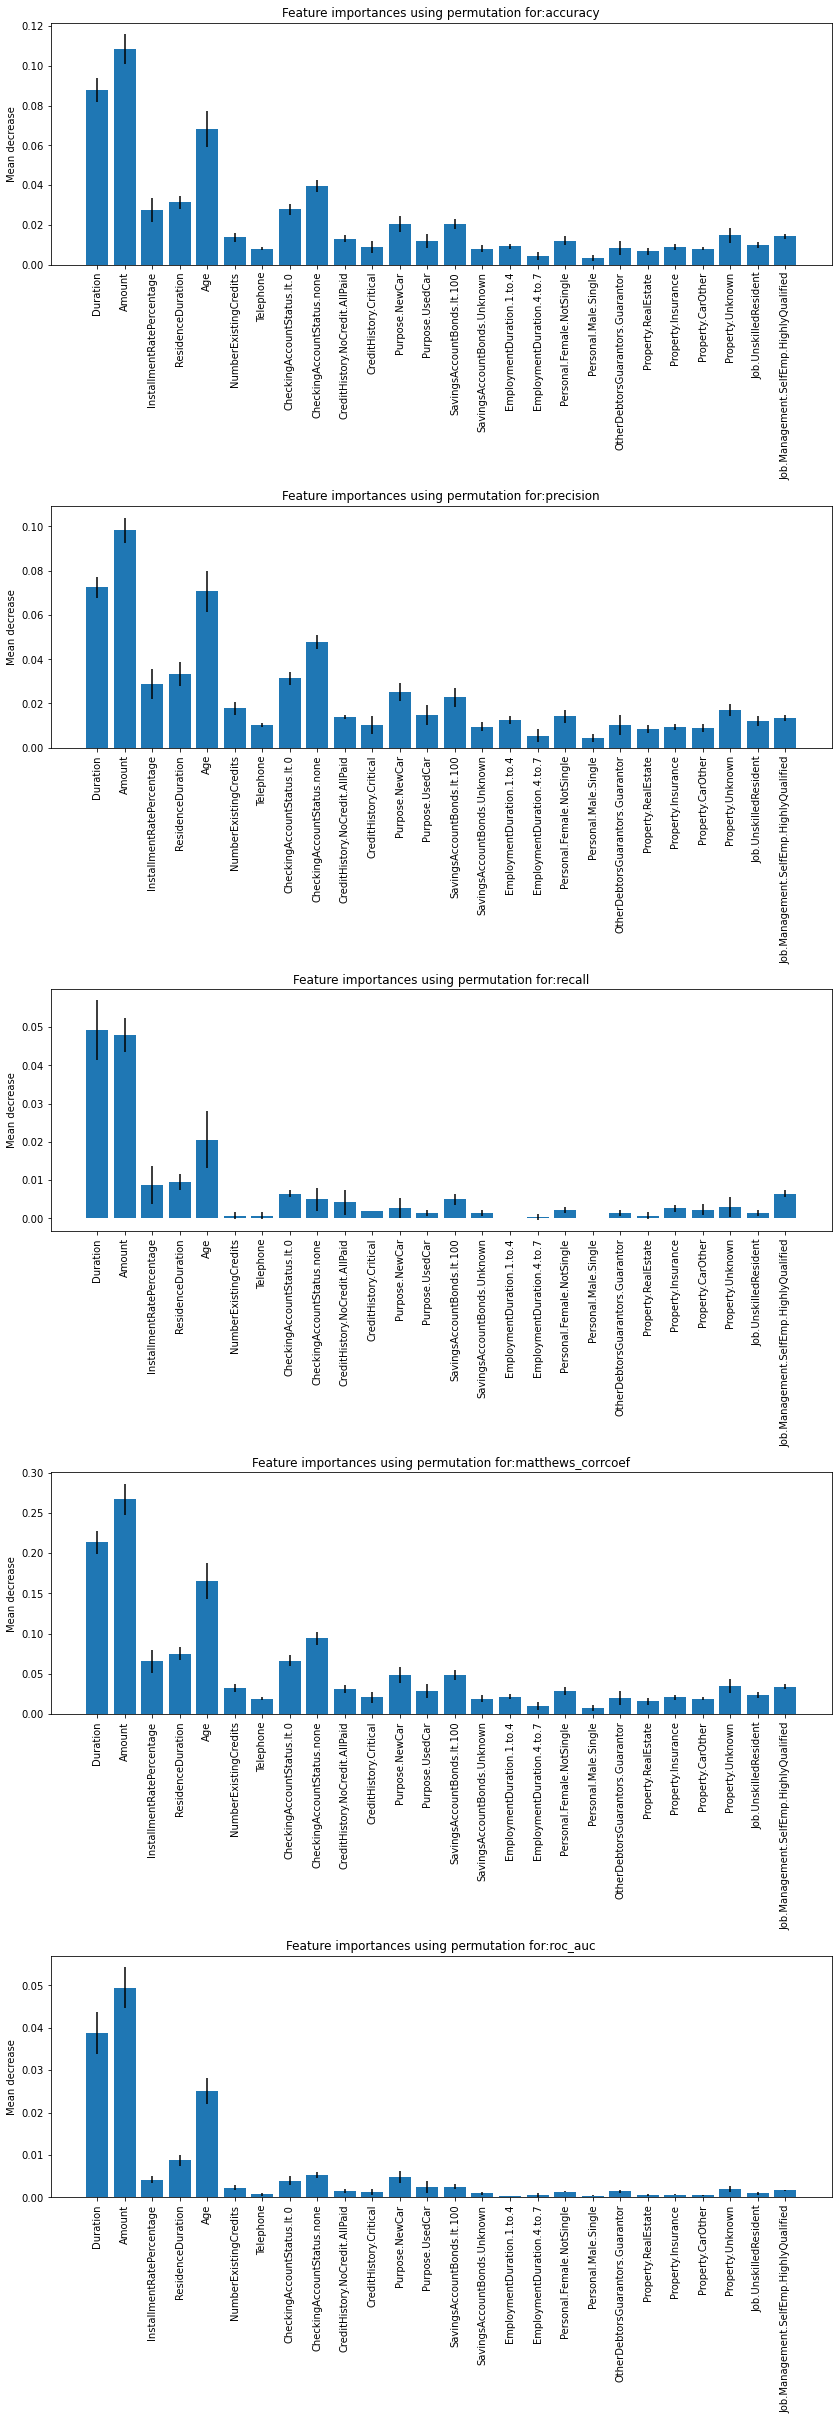

For main metric matthews_corrcoef test/train set, validation set, timeToProcess (min):

DecisionTreeClassifier 0.243 0.297 0.02
RandomForestClassifier 0.341 0.316 1.15
CatBoostClassifier 0.367 0.417 3.19


In [683]:
#re-run catBoost with fewer columns
regr=CatBoostClassifier(random_state=randomSeed)

start_time=time.time()
cv=GridSearchCV(estimator=regr,param_grid=catBoostParameters,scoring=scoring,verbose=verbose,error_score='raise',refit=mainMetric)
cv.fit(X_train, y_train)
bestEstimator=cv.best_estimator_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute model and metrics: {elapsed_time:.3f} seconds")
allResults['CatBoostClassifier']={}
allResults['CatBoostClassifier']['testAndValidMetric']=modelSearchResults(cv,mainMetric,catBoostParameters,scoring)
allResults['CatBoostClassifier']['modelingTime']=elapsed_time
allResults['CatBoostClassifier']['bestEstimator']=bestEstimator

permutationFeatureDrop['CatBoostClassifier']=featurePermutation(bestEstimator, X_train, y_train, 5, randomSeed, scoring,mainMetricPermTreshold)



In [684]:
#re-run random forest with fewer columns
regr=RandomForestClassifier(random_state=randomSeed)

start_time=time.time()
cv=GridSearchCV(estimator=regr,param_grid=randomForestParameters,scoring=scoring,verbose=verbose,error_score='raise',refit=mainMetric)
cv.fit(X_train, y_train)
bestEstimator=cv.best_estimator_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute model and metrics: {elapsed_time:.3f} seconds")
allResults['RandomForestClassifier']={}
allResults['RandomForestClassifier']['testAndValidMetric']=modelSearchResults(cv,mainMetric,randomForestParameters,scoring)
allResults['RandomForestClassifier']['modelingTime']=elapsed_time
allResults['RandomForestClassifier']['bestEstimator']=bestEstimator

Elapsed time to compute model and metrics: 75.758 seconds
Iteration number for best matthews_corrcoef : 29

Parameters for model with best matthews_corrcoef from possible values:
 {'n_estimators': [100, 200], 'criterion': ['entropy'], 'max_depth': [10, 20, 50, 100, 250], 'max_leaf_nodes': [10, 50, 250, 1000, 2500, 10000]} :

n_estimators value: 200.0
criterion value: entropy
max_depth value: 50.0
max_leaf_nodes value: 250.0

Metrics for model with best matthews_corrcoef  from set of ['accuracy', 'precision', 'recall', 'matthews_corrcoef', 'roc_auc'] :

mean_test_accuracy value: 0.748
mean_test_precision value: 0.777
mean_test_recall value: 0.899
mean_test_matthews_corrcoef value: 0.346
mean_test_roc_auc value: 0.769

 matthews_corrcoef on validation set is 0.339 to be compared with test matthews_corrcoef of 0.346 , a 2.0 percent difference


In [685]:
print('For main metric',mainMetric,'test/train set, validation set, timeToProcess (min):\n')
for key in allResults:
    print(key,allResults[key]['testAndValidMetric'][0],allResults[key]['testAndValidMetric'][1],round(allResults[key]['modelingTime']/60.0,2))

For main metric matthews_corrcoef test/train set, validation set, timeToProcess (min):

DecisionTreeClassifier 0.243 0.297 0.02
RandomForestClassifier 0.346 0.339 1.26
CatBoostClassifier 0.367 0.417 3.19
